# House Prices: Advanced Regression Techniques
This notebook is the part of Project 3 of AITS Machine Learning Engineer Internship.

**Project** 

*Implement two neural networks (with 3 and 5 layers) regression to predict housing prices with dataset at  [https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)  and discuss accuracy of one over the other.* 

This notebook contains code supporting the report made regarding the project.

In [13]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import os

print(tf.__version__)

1.13.1


In [14]:
df = pd.read_csv('./KaggleData/train.csv') # Loading the dataset

## Data Cleaning

The first column, 'Id' was dropped as it would have very little impact on the target value.

**Categorical encoding**

The categorical columns have been converted to numerical data.For example if a column X has the values 'A', 'B' and 'C' distributed over the data they would be replaced by 0, 1 and 2.

**Null Values**

Null values have been imputed by the median of the non-null data of the same column.

*Exception:*
In the case of *GarageYrBlt* which is the year in which the garage was built the null values were replaced by the minimum of the non-null data under an intuitive assumption that the reason of the null value might be because of no prior records.

In [15]:
def clean_data(df):
    """
    Encoding the categorical data with labels (0,1,2,3..) and imputing Nan values
    in numerical data with the median of the non-Nan values of the column.
    """
    df = df.drop(columns=['Id'])
    for dt in df.columns:
        if str(df[dt].dtype) == 'object':
            df[dt] = df[dt].replace(to_replace=df[dt].unique(), value=list(range(len(df[dt].unique()))))
    
    #Filling na with min 
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].dropna().min())
    
    for dt in df.columns:
        if str(df[dt].dtype) != 'object' and df[dt].isna().sum() != 0:
            df[dt] = df[dt].fillna(df[dt].dropna().median())

    return df

df = clean_data(df)
print(df.isna().sum().sum())
df.head()

0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,0,65.0,8450,0,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
1,20,0,80.0,9600,0,0,0,0,0,1,...,0,0,0,0,0,5,2007,0,0,181500
2,60,0,68.0,11250,0,0,1,0,0,0,...,0,0,0,0,0,9,2008,0,0,223500
3,70,0,60.0,9550,0,0,1,0,0,2,...,0,0,0,0,0,2,2006,0,1,140000
4,60,0,84.0,14260,0,0,1,0,0,1,...,0,0,0,0,0,12,2008,0,0,250000


In [16]:
def test_train_split(df, target='SalePrice', ratio=0.8):
    """
    Splitting the data in a 80-20 ratio by default for training and
    cross validation.
    """
    train_dataset = df.sample(frac=ratio,random_state=0)
    test_dataset = df.drop(train_dataset.index)

    train_labels = train_dataset.pop(target)
    test_labels = test_dataset.pop(target)
    
    return train_dataset, test_dataset, train_labels, test_labels

train_dataset, test_dataset, train_labels, test_labels = test_train_split(df)

In [17]:
def normalize(df):
    """
    Normalizing data with a MinMax scaler.
    """
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

train_dataset = normalize(train_dataset)
test_dataset = normalize(test_dataset)
train_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,0.000000,0.00,0.164384,0.145911,0.0,0.0,0.333333,0.000000,0.0,0.75,...,0.0,0.0,0.0,0.00,0.0,0.0,0.181818,0.25,0.0,0.8
1,0.176471,0.00,0.198630,0.037485,0.0,0.0,0.000000,0.000000,0.0,0.00,...,0.0,0.0,0.0,0.25,0.0,0.0,0.636364,0.00,0.0,0.0
2,0.176471,0.00,0.164384,0.025907,0.0,0.0,0.333333,0.333333,0.0,0.50,...,0.0,0.0,0.0,0.00,0.0,0.0,0.545455,0.75,0.0,0.0
3,0.235294,0.00,0.212329,0.039894,0.0,0.0,0.000000,0.000000,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.181818,0.50,0.0,0.0
4,0.823529,0.25,0.000000,0.000950,0.0,0.0,0.000000,0.000000,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.181818,1.00,0.0,1.0


In [18]:
input_shape = len(train_dataset.keys())
def build_model(alpha=0.01, hidden_layers=2):
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, input_shape=[input_shape]))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    
    for i in range(hidden_layers-1):
        model.add(tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu))
        model.add(tf.keras.layers.Dropout(rate=0.2))
        
    model.add(tf.keras.layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(alpha)

    model.compile(loss='mean_squared_logarithmic_error',
                    optimizer=optimizer,
                    metrics=['mean_squared_logarithmic_error', 'mean_squared_error'])
    return model

model = build_model(alpha=0.001, hidden_layers=2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               10240     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
__________

![3 Layered Neural Network](https://miro.medium.com/max/1200/0*hzIQ5Fs-g8iBpVWq.jpg)

In [19]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.07673467],
       [-0.03423563],
       [-0.05038019],
       [-0.0615802 ],
       [-0.07858482],
       [ 0.00932783],
       [-0.12035863],
       [-0.07325569],
       [-0.15612888],
       [-0.09328017]], dtype=float32)

In [20]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_logarithmic_error,mean_squared_error,val_loss,val_mean_squared_logarithmic_error,val_mean_squared_error,epoch
95,0.031420,0.031420,1.653871e+09,0.019085,0.019085,1.370454e+09,95
96,0.031216,0.031216,1.618156e+09,0.019347,0.019347,1.231818e+09,96
97,0.032065,0.032065,1.751018e+09,0.020557,0.020557,1.230964e+09,97
98,0.032985,0.032985,1.739498e+09,0.018512,0.018512,1.263925e+09,98
99,0.032593,0.032593,1.643569e+09,0.018683,0.018683,1.326892e+09,99


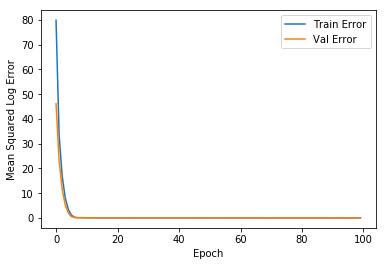

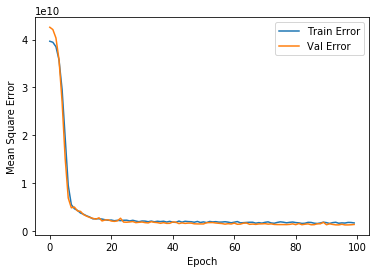

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Log Error')
  plt.plot(hist['epoch'], hist['mean_squared_logarithmic_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_logarithmic_error'],
           label = 'Val Error')
  plt.legend()


  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
    
  plt.show()


plot_history(history)

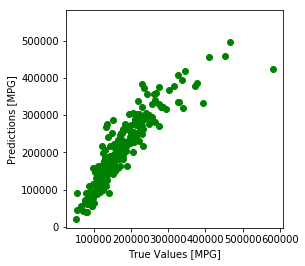

In [23]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions,c="green")
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.show()


In [24]:
test_df = pd.read_csv('./KaggleData/test.csv')

test_df = clean_data(test_df)
test_df = normalize(test_df)

predictions = model.predict(test_df).flatten()

ids = list(range(1461, 1461 + len(predictions)))
submission = pd.DataFrame()
submission['Id'] = ids
submission['SalePrice'] = predictions
submission.to_csv('./KaggleData/submission.csv')

assert len(predictions) == np.count_nonzero(~np.isnan(predictions))
print('CSV Saved')

CSV Saved
